In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists

import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss, Conv2d, Sequential, BatchNorm2d
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchinfo import summary

from ActiveShiftLayer import ASL
from util import test_loss, train_NN

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [3]:
batch_size = 100

#transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./data/MNIST",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./data/MNIST",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

In [4]:
input_shape = (batch_size, 1, 28, 28)
num_labels = 10

In [5]:
from Models import LeNet

LeNN = LeNet(input_shape, num_labels=num_labels, initial_lr=0.01, momentum=0.99, weight_decay=0)

summary(LeNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 28, 28]          156
│    └─BatchNorm2d: 2-2                  [100, 6, 28, 28]          12
│    └─Tanh: 2-3                         [100, 6, 28, 28]          --
│    └─AvgPool2d: 2-4                    [100, 6, 14, 14]          --
│    └─Conv2d: 2-5                       [100, 16, 14, 14]         2,416
│    └─BatchNorm2d: 2-6                  [100, 16, 14, 14]         32
│    └─Tanh: 2-7                         [100, 16, 14, 14]         --
│    └─AvgPool2d: 2-8                    [100, 16, 7, 7]           --
│    └─Flatten: 2-9                      [100, 784]                --
│    └─Linear: 2-10                      [100, 120]                94,200
│    └─Tanh: 2-11                        [100, 120]                --
│    └─

In [12]:
PATH = "models/LeNet/LeNet.pth"

if exists(PATH):
    LeNN = torch.load(PATH)
    LeNN.eval()

In [13]:
criterion = CrossEntropyLoss()

train_NN(LeNN, criterion, train_dataloader,
        test_dataloader, epochs=4, batches_to_test=100,patience=2,device=device, print_test=True, verbose=True)

[1,   100] train_loss: 0.923
test_loss: 0.512, test_accuracy: 85.66
[1,   200] train_loss: 0.334
test_loss: 0.389, test_accuracy: 87.87
[1,   300] train_loss: 0.181
test_loss: 0.161, test_accuracy: 95.08
[1,   400] train_loss: 0.159
test_loss: 0.094, test_accuracy: 97.14
[1,   500] train_loss: 0.116
test_loss: 0.090, test_accuracy: 97.28
[1,   600] train_loss: 0.115
test_loss: 0.090, test_accuracy: 97.29
[2,   100] train_loss: 0.080
test_loss: 0.119, test_accuracy: 96.33
[2,   200] train_loss: 0.077
test_loss: 0.080, test_accuracy: 97.45
[2,   300] train_loss: 0.072
test_loss: 0.068, test_accuracy: 97.89
[2,   400] train_loss: 0.073
test_loss: 0.090, test_accuracy: 97.3
[2,   500] train_loss: 0.072
test_loss: 0.075, test_accuracy: 97.78
[2,   600] train_loss: 0.069
test_loss: 0.073, test_accuracy: 97.89
[3,   100] train_loss: 0.056
test_loss: 0.054, test_accuracy: 98.45
[3,   200] train_loss: 0.054
test_loss: 0.060, test_accuracy: 98.23
[3,   300] train_loss: 0.047
test_loss: 0.070, te

In [14]:
torch.save(LeNN, "./models/LeNet/LeNet.pth")

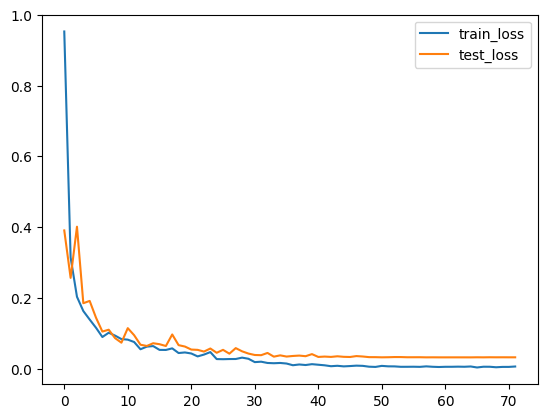

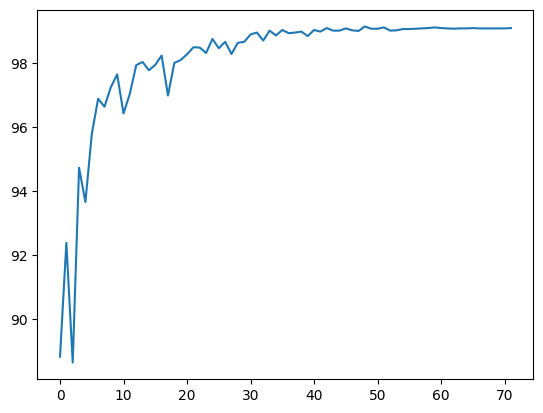

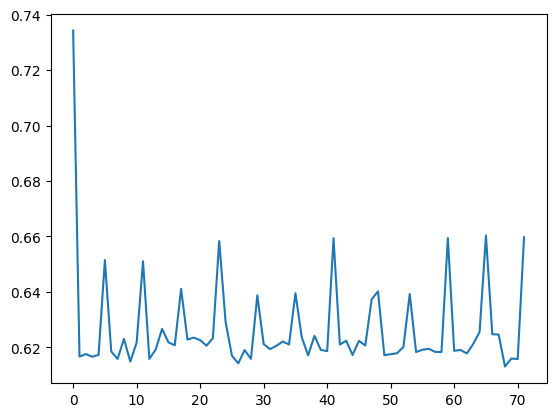

In [12]:
plt.plot(LeNN.train_loss, label="train_loss")
plt.plot(LeNN.test_loss, label = "test_loss")
plt.legend()
plt.show()
plt.plot(LeNN.test_accuracy)
plt.show()
plt.plot(LeNN.train_time)
plt.show()

In [7]:
from Models import LeASLNet

LeASLNN = LeASLNet(input_shape, num_labels, initial_lr=0.1, momentum=0.9, weight_decay=0, device=device, expansion_rate=1)

summary(LeASLNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeASLNet                                 [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 28, 28]          156
│    └─BatchNorm2d: 2-2                  [100, 6, 28, 28]          12
│    └─Tanh: 2-3                         [100, 6, 28, 28]          --
│    └─AvgPool2d: 2-4                    [100, 6, 14, 14]          --
│    └─CSC_block: 2-5                    [100, 16, 14, 14]         --
│    │    └─Sequential: 3-1              --                        108
│    │    └─Conv2d: 3-2                  [100, 16, 14, 14]         112
│    └─Tanh: 2-6                         [100, 16, 14, 14]         --
│    └─AvgPool2d: 2-7                    [100, 16, 7, 7]           --
│    └─Flatten: 2-8                      [100, 784]                --
│    └─Linear: 2-9                       [100, 120]                94,200
│    └─T

In [5]:
PATH = "models/LeNet/LeASLNet.pth"

if exists(PATH):
    LeASLNN = torch.load(PATH)
    LeASLNN.eval()

In [8]:
criterion = CrossEntropyLoss()

train_NN(LeASLNN, criterion, train_dataloader,
        test_dataloader, epochs=4, batches_to_test=100,patience=2,device=device, print_test=True, verbose=True)

[1,   100] train_loss: 0.722
test_loss: 0.213, test_accuracy: 93.4
[1,   200] train_loss: 0.211
test_loss: 0.121, test_accuracy: 96.09
[1,   300] train_loss: 0.120
test_loss: 0.124, test_accuracy: 96.04
[1,   400] train_loss: 0.109
test_loss: 0.093, test_accuracy: 97.07
[1,   500] train_loss: 0.090
test_loss: 0.156, test_accuracy: 94.89
[1,   600] train_loss: 0.107
test_loss: 0.108, test_accuracy: 96.86
[2,   100] train_loss: 0.082
test_loss: 0.067, test_accuracy: 97.82
[2,   200] train_loss: 0.078
test_loss: 0.078, test_accuracy: 97.57
[2,   300] train_loss: 0.065
test_loss: 0.061, test_accuracy: 98.09
[2,   400] train_loss: 0.075
test_loss: 0.074, test_accuracy: 97.58
[2,   500] train_loss: 0.073
test_loss: 0.069, test_accuracy: 97.85
[2,   600] train_loss: 0.062
test_loss: 0.062, test_accuracy: 98.01
[3,   100] train_loss: 0.048
test_loss: 0.062, test_accuracy: 98.04
[3,   200] train_loss: 0.067
test_loss: 0.060, test_accuracy: 98.02
[3,   300] train_loss: 0.052
test_loss: 0.057, te

In [8]:
torch.save(LeASLNN, "./models/LeNet/LeASLNet.pth")

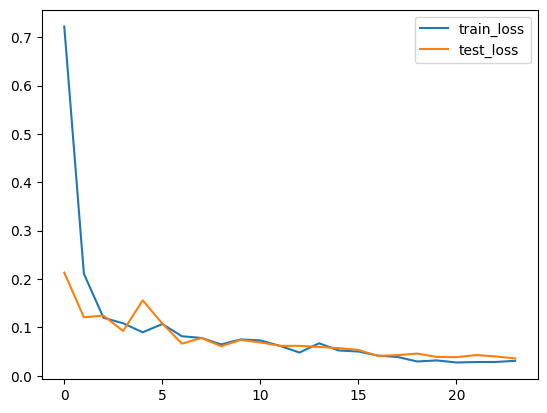

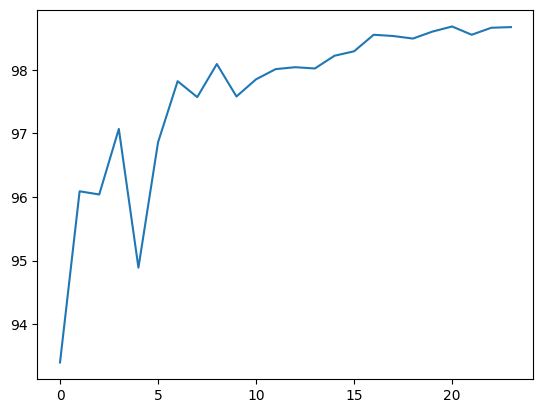

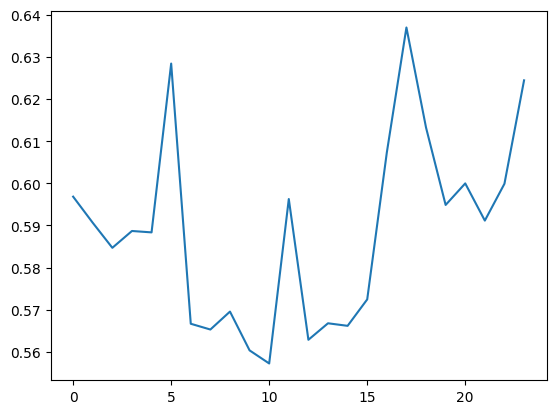

In [9]:
plt.plot(LeASLNN.train_loss, label="train_loss")
plt.plot(LeASLNN.test_loss, label="test_loss")
plt.legend()
plt.show()
plt.plot(LeASLNN.test_accuracy)
plt.show()
plt.plot(LeASLNN.train_time)
plt.show()

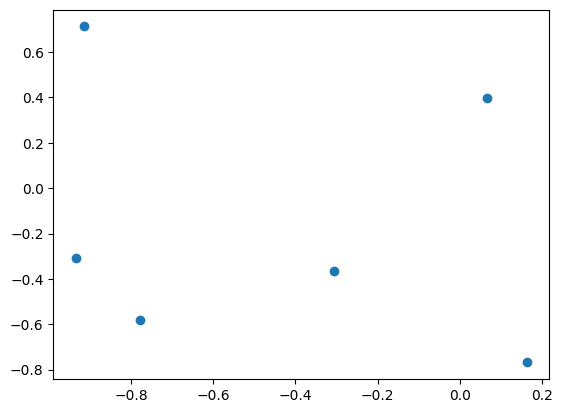

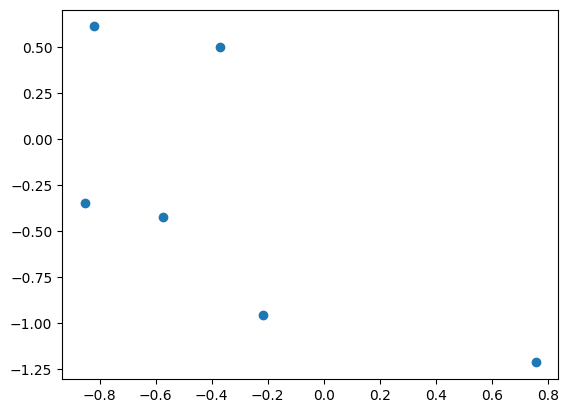

In [10]:
points = LeASLNN.NN[4].NN[3].shifts.detach().to("cpu").numpy()
initial_points = LeASLNN.NN[4].NN[3].initial.detach().to("cpu").numpy()
plt.scatter(initial_points[:, 0], initial_points[:,1])
plt.show()
plt.scatter(points[:, 0], points[:,1])
plt.show()

In [9]:
from Models import LeDepthNet

LeDepthNN = LeDepthNet(input_shape, num_labels, initial_lr=0.01, momentum=0.99, weight_decay=0, device=device)

summary(LeDepthNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeDepthNet                               [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 28, 28]          156
│    └─BatchNorm2d: 2-2                  [100, 6, 28, 28]          12
│    └─Tanh: 2-3                         [100, 6, 28, 28]          --
│    └─AvgPool2d: 2-4                    [100, 6, 14, 14]          --
│    └─Depth_wise_block: 2-5             [100, 16, 14, 14]         --
│    │    └─Sequential: 3-1              --                        226
│    └─Tanh: 2-6                         [100, 16, 14, 14]         --
│    └─AvgPool2d: 2-7                    [100, 16, 7, 7]           --
│    └─Flatten: 2-8                      [100, 784]                --
│    └─Linear: 2-9                       [100, 120]                94,200
│    └─Tanh: 2-10                        [100, 120]                --
│    └─Li

In [10]:
PATH = "models/LeNet/LeDepthNet.pth"

if exists(PATH):
    LeDepthNN = torch.load(PATH)
    LeDepthNN.eval()

In [15]:
criterion = CrossEntropyLoss()

train_NN(LeDepthNN, criterion, train_dataloader,
        test_dataloader, epochs=4, batches_to_test=100,patience=2,device=device, print_test=True, verbose=True)

[1,   100] train_loss: 0.036
test_loss: 0.047, test_accuracy: 98.46
[1,   200] train_loss: 0.034
test_loss: 0.048, test_accuracy: 98.42
[1,   300] train_loss: 0.032
test_loss: 0.049, test_accuracy: 98.44
[1,   400] train_loss: 0.040
test_loss: 0.050, test_accuracy: 98.42
[1,   500] train_loss: 0.039
test_loss: 0.050, test_accuracy: 98.38
Epoch 00006: reducing learning rate of group 0 to 1.2500e-03.
[1,   600] train_loss: 0.037
test_loss: 0.046, test_accuracy: 98.53
[2,   100] train_loss: 0.029
test_loss: 0.046, test_accuracy: 98.59
[2,   200] train_loss: 0.029
test_loss: 0.046, test_accuracy: 98.56
[2,   300] train_loss: 0.030
test_loss: 0.045, test_accuracy: 98.57
Epoch 00010: reducing learning rate of group 0 to 6.2500e-04.
[2,   400] train_loss: 0.031
test_loss: 0.045, test_accuracy: 98.57
[2,   500] train_loss: 0.028
test_loss: 0.045, test_accuracy: 98.58
[2,   600] train_loss: 0.027
test_loss: 0.044, test_accuracy: 98.62
[3,   100] train_loss: 0.029
test_loss: 0.045, test_accuracy

In [16]:
torch.save(LeDepthNN, "./models/LeNet/LeDepthNet.pth")

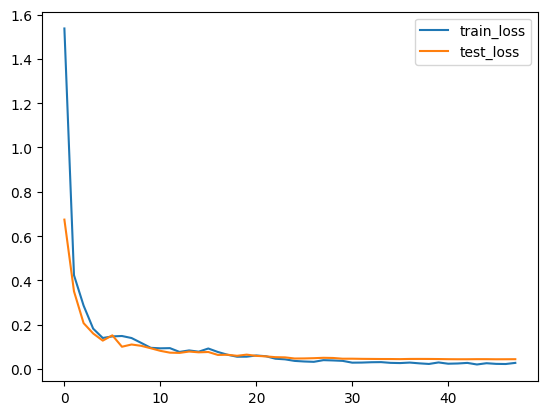

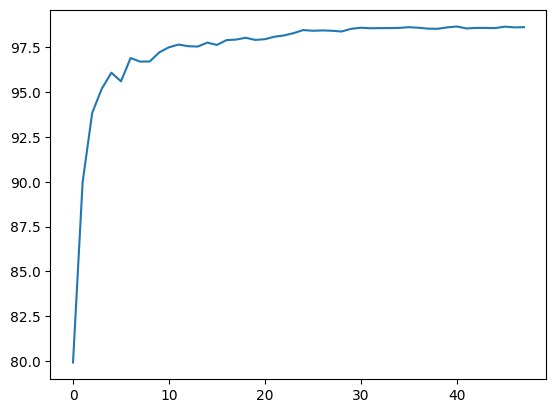

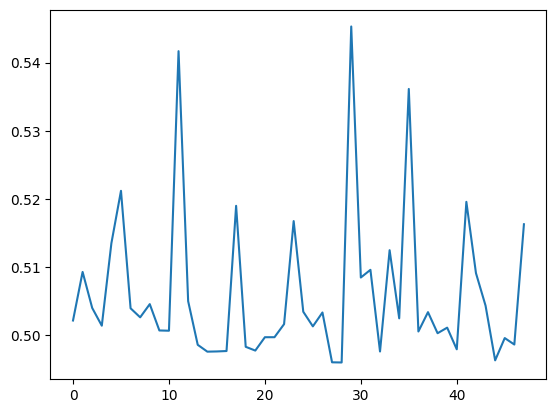

In [17]:
plt.plot(LeDepthNN.train_loss, label="train_loss")
plt.plot(LeDepthNN.test_loss, label="test_loss")
plt.legend()
plt.show()
plt.plot(LeDepthNN.test_accuracy)
plt.show()
plt.plot(LeDepthNN.train_time)
plt.show()